<a href="https://colab.research.google.com/github/lfreese/NEI/blob/master/faculty_geosciences_plotting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook to analyze Faculty in Geosciences Data

All data was taken from the google drive spreadsheet where we looked at 62 different Universities and their faculty makeup

Shift + enter to run a cell!

## Import Dependencies and Set up Notebook with Drive

In [ ]:
#import necessary authorizations for google colab
from google.colab import auth
auth.authenticate_user()
import gspread
from oauth2client.client import GoogleCredentials
gc = gspread.authorize(GoogleCredentials.get_application_default()) #this will allow us to open URLs

#when you run this cell, you will see a link pop up below. 
#Click on it and copy and paste the password it gives you into the box that appears below. 
#This authorizes the google drive to be used

In [ ]:
#import dependencies
import pandas as pd #for those new to python, pandas will be what we use to make our 'dataframes' and is the easiest way to manipulate this data
import matplotlib.pyplot as plt #matplotlib is how we plot
import numpy as np
from scipy.stats import pearsonr

# Create Dataframe

In [ ]:
#faculty data sheet
url = 'https://docs.google.com/spreadsheets/d/15hTMQ6iJyZwiYT4Imb072qraBreUbsGWZOhFrqx5hIo/edit?usp=drive_web&ouid=117317098944838060110' #url of our google drive document
wb = gc.open_by_url(url) #open our url as a workbook

In [ ]:
#get data from the workbook and convert to a pandas dataframe
sheet = wb.worksheet('Faculty Database: Finalized') #choose the sheet to import
data = sheet.get_all_values()

df = pd.DataFrame(data) #create our dataframe of the data
df.columns = df.iloc[0] #fix some issues with the column and rows (hash this if you want to see why I do it)
df = df.iloc[1:]


In [ ]:
# department heads

#get data from the workbook and convert to a pandas dataframe
sheet = wb.worksheet('Department Chairs') #choose the sheet to import
data = sheet.get_all_values()

dfc = pd.DataFrame(data) #create our dataframe of the data
dfc
dfc.columns = dfc.iloc[0] #fix some issues with the column and rows (hash this if you want to see why I do it)
dfc = dfc.iloc[1:]

In [ ]:
#assign department heads

for univ in dfc['University']:
  df.loc[df['University'] == univ, 'dept_head_gender'] = dfc.loc[dfc['University'] == univ, 'Gender'].values[0]

In [ ]:
# grad students and postdocs

#get data from the workbook and convert to a pandas dataframe
sheet = wb.worksheet('grad_postdoc') #choose the sheet to import
data = sheet.get_all_values()

dfg = pd.DataFrame(data) #create our dataframe of the data
dfg = dfg.iloc[:,1:10]
dfg.columns = ['university','grad M 2018','grad F 2018','grad M 2017','grad F 2017',
               'pd M 2018','pd F 2018','pd M 2017','pd F 2017']
dfg = dfg.drop(np.arange(0,7))

# Harvard, NC State, and William & Mary not included in this database

In [ ]:
# grad students over all years

sheet = wb.worksheet('Grad Students') #choose the sheet to import
data = sheet.get_all_values()
dfg_all = pd.DataFrame(data)
dfg_all = dfg_all.T
dfg_all = dfg_all.iloc[1:39,0:3]
dfg_all.columns = ['Year','Male','Female']

## Modify Our Data

In [ ]:
# remove joint appointments
indexNames = df[(df['Other Department (if Joint Appt)'].str.contains("1st"))].index

df.drop(indexNames, inplace = True)


In [ ]:
# put all columns in lowercase for consistency
for column in df.columns:
  df[column] = df[column].str.lower()
dfg['university'] = dfg['university'].str.lower()

In [ ]:
#add public private status
public_private = {'Arizona State':'public', 
                      'Berkeley':'public', 
                      'Brown':'private', 
                      'Caltech':'private', 
                      'CO Mines':'private',
                      'Colorado State University':'public', 
                      'Columbia':'private', 
                      'Cornell':'private', 
                      'CU Boulder':'public',
                      'Florida State':'public', 
                      'Georgia Tech':'public', 
                      'Harvard':'private', 
                      'Indiana U':'public',
                      'Johns Hopkins':'private', 
                      'LSU':'public', 
                      'MIT':'private', 
                      'NC State':'public', 
                      'Ohio State University':'public',
                      'Oregon State':'public', 
                      'Penn State':'public', 
                      'Princeton':'private', 
                      'Purdue':'public', 
                      'Rice':'private',
                      'Rutgers':'public', 
                      'Stanford':'private', 
                      'Stony Brook U':'public', 
                      'SUNY Albany':'public', 
                      'Texas A&M':'public',
                      'U Alaska Fairbanks':'public', 
                      'U Arizona':'public', 
                      'U Chicago':'private', 
                      'U Delaware':'public',
                      'U Hawaii':'public', 
                      'U Houston':'public', 
                      'U Iowa':'public', 
                      'U Kansas':'public', 
                      'U Miami':'public',
                      'U Michigan':'public', 
                      'U Minnesota Twin Cities':'public', 
                      'U Nevada Reno':'public',
                      'U Oklahoma Norman':'public', 
                      'U Rhode Island':'public', 
                      'U South Carolina':'public',
                      'U South Florida':'public', 
                      'U Utah':'public', 
                      'U Washington':'public', 
                      'U Wyoming':'public',
                      'UC Davis':'public', 
                      'UCLA':'public', 
                      'UCSB':'public', 
                      'UCSC':'public', 
                      'UCSD':'public', 
                      'UIUC':'public', 
                      'UMD':'public',
                      'UNC Chapel Hill':'public',
                        'USC':'public', 
                        'UT':'public', 
                        'UT Dallas':'public', 
                        'UW Madison':'public',
                      'Virginia Polytechnic':'public', 
                      'William & Mary':'public', 
                      'Yale':'private'}
# add in the public private status of the university
for university in public_private.keys():
  df.loc[df['University'] == university.lower(),'private_public'] = public_private[university]


In [ ]:

#create a category for earth, atmosphere, ocean, planet
for field in ['geo','marine geology']:
  df.loc[df['Discipline'].str.contains(field), 'EPAO'] = 'Earth'
#for field in ['marine geology']:
  #df.loc[df['Discipline'].str.contains(field), 'EPAO'] = 'Earth'
for field in ['atmos']:
  df.loc[df['Discipline'].str.contains(field), 'EPAO'] = 'Atmosphere'
for field in ['ocean', 'marine biology']:
  df.loc[df['Discipline'].str.contains(field), 'EPAO'] = 'Ocean'
#for field in ['marine biology']:
  #df.loc[df['Discipline'].str.contains(field), 'EPAO'] = 'Ocean'
for field in ['planet']:
  df.loc[df['Discipline'].str.contains(field), 'EPAO'] = 'Planet'

In [ ]:
#I'm unclear what all of these smaller categories are, 
#and they make the pie chart quite confusing, so I'm dropping them just for ease of showing what we can do
#I assume we should combine all Asst. Profs (senior reserach and directors) into one category eventually?
indexNames = df[(df['Career Stage'] == 'assistant professor (senior research)') | 
                (df['Career Stage'] == 'associate professor (senior research)')|
                (df['Career Stage'] == 'associate professor/director')| 
                (df['Career Stage'] == '???')|
                (df['Career Stage'] == '')|
                (df['Career Stage'] == 'professor (senior research)')|
                (df['Career Stage'] == 'provostial professor')|
                (df['Gender'] == '')].index

df.drop(indexNames, inplace = True)

 ## Cleaning Up Data for Publication

In [ ]:
# Compile the faculty in each subdiscipline
import numpy as np
# the subdisciplines: Atmospheric Chemistry, Atmospheric Dynamics, Geology, Geophysics, Paleoclimate, Geochemistry, Geobiology, Chemical Oceanography, Biological Oceanography
# Physical Oceanography, Glaciology, Hydrology, Planetary Sciences, Climate Dynamics, GIS/Engineering, Geopolitics/Impacts, Sustainability, Resource Management
# Geomorphology, Ecology, Paleontology , Paleobiology, Land Surface Processes, Education, Marine Geology, Paleoceanography, Ocean Acoustics. Marine Biology, History of Science

atmoschem = df[df['Discipline'].str.contains("atmospheric chemistry")] # find all the atmospheric chemists in the dataset
atmosdyn = df[df['Discipline'].str.contains("atmospheric dynamics")] # find all the atmospheric dynamicists in the dataset
geology = df[df['Discipline'].str.contains("geology")] # find all the geologists in the dataset
geophysics = df[df['Discipline'].str.contains("geophysics")] # find all the geophysicists in the dataset
paleoclimate = df[df['Discipline'].str.contains("paleoclimate")] # find all the paleoclimatologists in the dataset
geochem = df[df['Discipline'].str.contains("geochemistry")] # find all the geochemists in the dataset
geobio = df[df['Discipline'].str.contains("geobiology")] # find all the geobiologists in the dataset
chemocean = df[df['Discipline'].str.contains("chemical oceanography")] # find all the chemical oceanographers in the dataset
bioocean = df[df['Discipline'].str.contains("biological oceanography")] # find all the biological oceanographers in the dataset
physocean = df[df['Discipline'].str.contains("physical oceanography")] # find all the physical oceanographers in the dataset
glaciology = df[df['Discipline'].str.contains("glaciology")] # find all the glaciologists in the dataset
planetary = df[df['Discipline'].str.contains("planetary")] # find all the planetary scientists in the dataset
geomorph = df[df['Discipline'].str.contains("geomorphology")] # find all the geomorphologists in the dataset
marinegeo = df[df['Discipline'].str.contains("marine geology")] # find all the marine geologists in the dataset
paleocean = df[df['Discipline'].str.contains("paleoceanography")] # find all the paleoceanographers in the dataset
marinebio = df[df['Discipline'].str.contains("marine biology")] # find all the marine biologists in the dataset
biogeochemistry = df[df['Discipline'].str.contains("biogeochemistry")] # find all the science historians in the dataset

gender_atmoschem = atmoschem.groupby(['Gender','Career Stage']).count()['Name'] # look at their genders
gender_atmosdyn = atmosdyn.groupby(['Gender','Career Stage']).count()['Name'] # look at their genders
gender_geology = geology.groupby(['Gender','Career Stage']).count()['Name'] # look at their genders
gender_geophysics = geophysics.groupby(['Gender','Career Stage']).count()['Name'] # look at their genders
gender_paleoclimate = paleoclimate.groupby(['Gender','Career Stage']).count()['Name'] # look at their genders
gender_geochem = geochem.groupby(['Gender','Career Stage']).count()['Name'] # look at their genders
gender_geobio = geobio.groupby(['Gender','Career Stage']).count()['Name'] # look at their genders
gender_chemocean = chemocean.groupby(['Gender','Career Stage']).count()['Name'] # look at their genders
gender_bioocean = bioocean.groupby(['Gender','Career Stage']).count()['Name'] # look at their genders
gender_physocean = physocean.groupby(['Gender','Career Stage']).count()['Name'] # look at their genders
gender_glaciology = glaciology.groupby(['Gender','Career Stage']).count()['Name'] # look at their genders
gender_planetary = planetary.groupby(['Gender','Career Stage']).count()['Name'] # look at their genders
gender_geomorph = geomorph.groupby(['Gender','Career Stage']).count()['Name'] # look at their genders
gender_marinegeo = marinegeo.groupby(['Gender','Career Stage']).count()['Name'] # look at their genders
gender_paleocean = paleocean.groupby(['Gender','Career Stage']).count()['Name'] # look at their genders
gender_marinebio = marinebio.groupby(['Gender','Career Stage']).count()['Name'] # look at their genders
gender_biogeochemistry = biogeochemistry.groupby(['Gender','Career Stage']).count()['Name'] # look at their genders

cleaned_data = np.empty(shape=(17,7),dtype='object') 
string = ['Atmospheric Chemistry','Atmospheric Dynamics','Geology','Geophysics','Paleoclimate','Geochemistry','Geobiology','Chemical Oceanography','Biological Oceanography','Physical Oceanography','Glaciology','Planetary Science','Geomorphology','Marine Geology','Paleoceanography','Marine Biology','Biogeochemistry']
data_collect = [gender_atmoschem,gender_atmosdyn,gender_geology,gender_geophysics,gender_paleoclimate,gender_geochem,gender_geobio,gender_chemocean,gender_bioocean,gender_physocean,gender_glaciology,gender_planetary,gender_geomorph,gender_marinegeo,gender_paleocean,gender_marinebio,gender_biogeochemistry]
cleaned_data[0,0] = 'Subdiscipline'
cleaned_data[0,1] = 'Female Assistant Professors'
cleaned_data[0,2] = 'Female Associate Professors'
cleaned_data[0,3] = 'Female Full Professors'
cleaned_data[0,4] = 'Male Assistant Professors'
cleaned_data[0,5] = 'Male Associate Professors'
cleaned_data[0,6] = 'Male Full Professors'
for i in range(16):
  i = i+1
  cleaned_data[i,0] = string[i]
  data = data_collect[i]
  if string[i]=='Marine Geology':
    cleaned_data[i,1] = 0
    cleaned_data[i,2] = data[0]
    cleaned_data[i,3] = data[1]
    cleaned_data[i,4] = data[2]
    cleaned_data[i,5] = data[3]
    cleaned_data[i,6] = data[4]
  elif string[i]=='Marine Biology':
    cleaned_data[i,1] = data[0]
    cleaned_data[i,2] = 0
    cleaned_data[i,3] = data[1]
    cleaned_data[i,4] = data[2]
    cleaned_data[i,5] = data[3]
    cleaned_data[i,6] = data[4]
  else:
    cleaned_data[i,1] = data[0]
    cleaned_data[i,2] = data[1]
    cleaned_data[i,3] = data[2]
    cleaned_data[i,4] = data[3]
    cleaned_data[i,5] = data[4]
    cleaned_data[i,6] = data[5]

print(cleaned_data)
pd.DataFrame(cleaned_data).to_csv("data_gender_subdiscipline_0920.csv")

[['Subdiscipline' 'Female Assistant Professors'
  'Female Associate Professors' 'Female Full Professors'
  'Male Assistant Professors' 'Male Associate Professors'
  'Male Full Professors']
 ['Atmospheric Dynamics' 20 15 21 30 34 128]
 ['Geology' 41 27 61 47 61 256]
 ['Geophysics' 25 20 41 42 45 185]
 ['Paleoclimate' 9 8 21 14 19 42]
 ['Geochemistry' 63 43 73 45 64 251]
 ['Geobiology' 17 12 23 14 12 60]
 ['Chemical Oceanography' 15 10 15 12 12 44]
 ['Biological Oceanography' 15 15 23 16 12 63]
 ['Physical Oceanography' 10 8 18 17 19 96]
 ['Glaciology' 6 3 4 9 4 16]
 ['Planetary Science' 14 10 15 16 15 73]
 ['Geomorphology' 7 5 5 14 11 37]
 ['Marine Geology' 0 2 6 1 1 16]
 ['Paleoceanography' 5 1 8 2 7 13]
 ['Marine Biology' 3 0 4 1 1 14]
 ['Biogeochemistry' 25 26 32 17 31 96]]


# Plots

In [ ]:
#set colors for subdisciplines and for gender
field_colors = {'Atmosphere':'forestgreen',
             'Ocean': 'lightblue',
             'Earth':'darkgoldenrod',
             'Planets':'mediumslateblue'}

prof_colors = {'assistant professor':'lightsteelblue', 
               'associate professor':'dodgerblue', 
               'professor':'darkslateblue'}
gender_colors = {'female':'darkgreen',
                  'male':'yellowgreen'}

# PhDs and Postdocs

In [ ]:
percent_female_prof = []
uni_type = []
for u in dfg['university'].iloc[:-1]:
  uni = df.loc[(df['University'].str.contains(u))]
  grouped_uni = uni.groupby('Gender').count()['Name']
  percent_female_uni = grouped_uni['f']/(grouped_uni['f']+grouped_uni['m'])
  percent_female_prof = np.append(percent_female_prof,percent_female_uni)
  if df.loc[(df['University'].str.contains(u)),'private_public'].iloc[0] == 'public':
    uni_type = np.append(uni_type,0)
  elif df.loc[(df['University'].str.contains(u)),'private_public'].iloc[0] == 'private':
    uni_type = np.append(uni_type,1)
  elif u == 'caltech':
    uni_type = np.append(uni_type,1)
percent_female_prof = np.append(percent_female_prof,0) # add UT Dallas manually, no female profs
uni_type = np.append(uni_type,0)

In [ ]:
GF17 = np.array([int(numeric_string) for numeric_string in dfg['grad F 2017']])
GM17 = np.array([int(numeric_string) for numeric_string in dfg['grad M 2017']])
GF18 = np.array([int(numeric_string) for numeric_string in dfg['grad F 2018']])
GM18 = np.array([int(numeric_string) for numeric_string in dfg['grad M 2018']])
PF17 = np.array([int(numeric_string) for numeric_string in dfg['pd F 2017']])
PM17 = np.array([int(numeric_string) for numeric_string in dfg['pd M 2017']])
PF18 = np.array([int(numeric_string) for numeric_string in dfg['pd F 2018']])
PM18 = np.array([int(numeric_string) for numeric_string in dfg['pd M 2018']])

In [ ]:
percent_female_grad = (GF17+GF18)/(GF17+GF18+GM17+GM18)
percent_female_pd = (PF17+PF18)/(PF17+PF18+PM17+PM18)

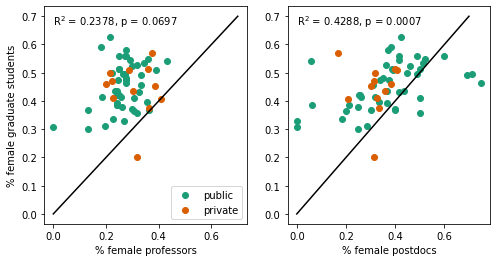

In [ ]:
fig, axs = plt.subplots(1,2,figsize = (8,4))
ax = axs[0]
a = ax.scatter(percent_female_prof[uni_type == 0],percent_female_grad[uni_type == 0],c = '#1b9e77')
b = ax.scatter(percent_female_prof[uni_type == 1],percent_female_grad[uni_type == 1],c = '#d95f02')
ax.legend([a,b],(('public','private')))
ax.plot([0,0.7],[0,0.7],color = 'k')
ax.set_xlabel('% female professors')
ax.set_ylabel('% female graduate students')
tmp = pearsonr(percent_female_prof,percent_female_grad)
ax.text(0,0.67,r'R$^2$ = '+str(np.round(tmp[0],4))+', p = '+str(np.round(tmp[1],4)))
ax = axs[1]
a = ax.scatter(percent_female_pd[uni_type == 0],percent_female_grad[uni_type == 0],c = '#1b9e77')
b = ax.scatter(percent_female_pd[uni_type == 1],percent_female_grad[uni_type == 1],c = '#d95f02')
ax.plot([0,0.7],[0,0.7],color = 'k')
ax.set_xlabel('% female postdocs')
tmp = pearsonr(percent_female_pd,percent_female_grad)
ax.text(0,0.67,r'R$^2$ = '+str(np.round(tmp[0],4))+', p = '+str(np.round(tmp[1],4)))
fig.savefig('grad_postdoc_faculty_public_private.png')

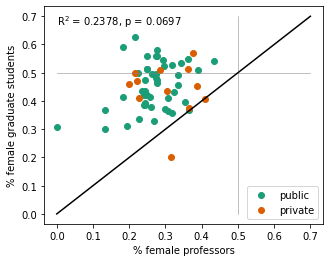

In [ ]:
fig, axs = plt.subplots(1,1,figsize = (5,4))
ax = axs
a = ax.scatter(percent_female_prof[uni_type == 0],percent_female_grad[uni_type == 0],c = '#1b9e77')
b = ax.scatter(percent_female_prof[uni_type == 1],percent_female_grad[uni_type == 1],c = '#d95f02')
ax.legend([a,b],(('public','private')),loc = 'lower right')
ax.plot([0.5,0.5],[0,0.7],color = 'grey',linewidth = 0.5)
ax.plot([0,0.7],[0.5,0.5],color = 'grey',linewidth = 0.5)
ax.plot([0,0.7],[0,0.7],color = 'k')
ax.set_xlabel('% female professors')
ax.set_ylabel('% female graduate students')
tmp = pearsonr(percent_female_prof,percent_female_grad)
ax.text(0,0.67,r'R$^2$ = '+str(np.round(tmp[0],4))+', p = '+str(np.round(tmp[1],4)))
fig.savefig('grad_faculty_public_private.png')

# Percent of Female Geoscience Faculty Through Time

In [ ]:
# comparing our results with results from previous studies
# 1999 Data: 22% asst prof, 14% assoc prof, 5% prof, 12.5% total (de Wet
# 2002, Claudy 1999, Wolfe 1999)

# 2002-2003 Data: 26% asst prof, 15% assoc prof, 8% prof, 13% total (Holmes
# and O'Connell 2003)

# 2008 Data: 27% asst prof, 15% assoc prof, 8% prof (Wilson 2016)

# 2010 Data: 30% asst prof, 18% assoc prof, 10% prof (Wilson 2016)

# 2013 Data: 32% asst prof, 21% assoc prof, 11% prof, 17% total (Wilson 2016)

# 2015 Data: 36% asst prof, 24% assoc prof, 13% prof, 20% total (Glass
# 2015)

# 2020 Data: 46% asst prof, 34% assoc prof, 19% prof, 27.6% total (Us)

# get rid of other career stages
indexNames = df[(df['Career Stage'] == 'assistant professor (senior research)') | 
                (df['Career Stage'] == 'associate professor (senior research)')|
                (df['Career Stage'] == 'associate professor/director')| 
                (df['Career Stage'] == '???')|
                (df['Career Stage'] == '')|
                (df['Career Stage'] == 'professor (senior research)')|
                (df['Career Stage'] == 'provostial professor')].index
df.drop(indexNames, inplace = True)

# determine the gender breakdown
gender_breakdown = df.groupby(['Gender','Career Stage']).count()['Name']
gender_breakdown_total = df.groupby(['Gender']).count()['Name']

gender_breakdown_total
# display the gender breakdown
#df.groupby(['Gender','Career Stage']).count()['Name']
#df.groupby(['Gender']).count()['Name']

Gender
f     688
m    1798
Name: Name, dtype: int64

In [ ]:
# compute percent of women in each career stage in 2020

percent_female_asstprof20 = (gender_breakdown[0]/(gender_breakdown[0]+gender_breakdown[3]))*100
percent_female_assocprof20 = (gender_breakdown[1]/(gender_breakdown[1]+gender_breakdown[4]))*100
percent_female_prof20 = (gender_breakdown[2]/(gender_breakdown[2]+gender_breakdown[5]))*100
percent_female_total20 = (gender_breakdown_total[0])/(gender_breakdown_total[0]+gender_breakdown_total[1])*100

In [ ]:
# adding in the other years of data

percent_female_asstprof = [22, 26, 27, 30, 32, 36, percent_female_asstprof20]
percent_female_assocprof = [14, 15, 15, 18, 21, 24, percent_female_assocprof20]
percent_female_prof = [5, 8, 8, 10, 11, 13, percent_female_prof20]

percent_female_total = [12.5, 13, 17, 20, percent_female_total20]

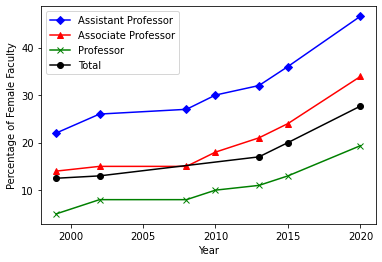

In [ ]:
# plot the percent of female geoscientists over years

years = [1999, 2002, 2008, 2010, 2013, 2015, 2020]
years_total = [1999, 2002, 2013, 2015, 2020]

plt.plot(years, percent_female_asstprof,'bD-', label='Assistant Professor')
plt.plot(years, percent_female_assocprof,'r^-', label='Associate Professor')
plt.plot(years, percent_female_prof,'gx-', label = 'Professor')
plt.plot(years_total, percent_female_total,'ko-', label = 'Total')
plt.legend();
#plt.grid()
plt.xlabel('Year');
plt.ylabel('Percentage of Female Faculty');
plt.savefig('percentfemalefaculty_time.png')

(0.5, 1.2)

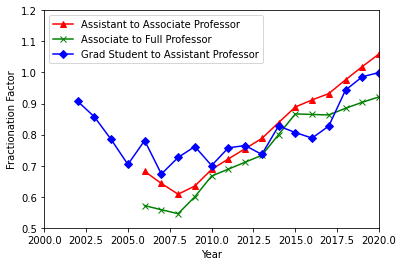

In [ ]:
# plot the fractionation of female geoscientists when accounting for time to promotion

from scipy.interpolate import interp1d

years_sparse = [1999, 2002, 2008, 2010, 2013, 2015, 2020];
years = list(range(1999,2021))


f1 = interp1d(years_sparse,percent_female_asstprof);
f2 = interp1d(years_sparse,percent_female_assocprof);
f3 = interp1d(years_sparse,percent_female_prof);

percent_asst_new = f1(years) 
percent_assoc_new = f2(years)
percent_prof_new = f3(years)

percent_gradstudents = []
for i in range(len(dfg_all)):
  percent_gradstudents.append(pd.to_numeric(dfg_all.loc[i+1][2])/(pd.to_numeric(dfg_all.loc[i+1][1])+pd.to_numeric(dfg_all.loc[i+1][2]))*100)
percent_gradstudents.reverse()
percent_gradstudents_new = percent_gradstudents[18:38]
percent_gradstudents_new.append(0)
percent_gradstudents_new.append(0)
years = list(range(1981,2019))

# assume 7 years to tenure, 3 years from graduating to assistant professorship
# for the sake of 'error' we can shift everything +/- 2 years
frac_assocprof = []
frac_asstassoc = []
for i in range(15): #15(0-14)
  frac_asstassoc.append(percent_assoc_new[i+7]/percent_asst_new[i]) #7
  frac_assocprof.append(percent_prof_new[i+7]/percent_assoc_new[i]) #7

frac_gradasst = []
for i in range(19): #19
  frac_gradasst.append(percent_asst_new[i+3]/percent_gradstudents_new[i]) #3

plt.plot(list(range(2006,2021)), frac_asstassoc,'r^-', label='Assistant to Associate Professor')
plt.plot(list(range(2006,2021)), frac_assocprof,'gx-', label='Associate to Full Professor')
plt.plot(list(range(2002,2021)), frac_gradasst,'bD-', label='Grad Student to Assistant Professor')
plt.legend();
#plt.grid()
plt.xlabel('Year');
plt.ylabel('Fractionation Factor');
plt.savefig('fractionation_yearstopromotion.png')
plt.xlim([2000, 2020])
plt.ylim([0.5, 1.2])


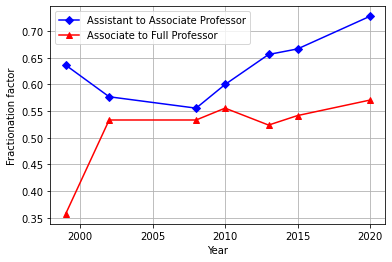

In [ ]:
# plot the fractionation of female geoscientists over years

years = [1999, 2002, 2008, 2010, 2013, 2015, 2020]

plt.plot(years, np.array(percent_female_assocprof)/np.array(percent_female_asstprof),'bD-', label='Assistant to Associate Professor')
plt.plot(years, np.array(percent_female_prof)/np.array(percent_female_assocprof),'r^-', label='Associate to Full Professor')
plt.legend();
plt.grid()
plt.xlabel('Year');
plt.ylabel('Fractionation factor');
plt.savefig('fractionation_time.png')

In [ ]:
# Grad students through the years 1981-2018

percent_gradstudents = []
for i in range(len(dfg_all)):
  percent_gradstudents.append(pd.to_numeric(dfg_all.loc[i+1][2])/(pd.to_numeric(dfg_all.loc[i+1][1])+pd.to_numeric(dfg_all.loc[i+1][2]))*100)

percent_gradstudents.reverse()

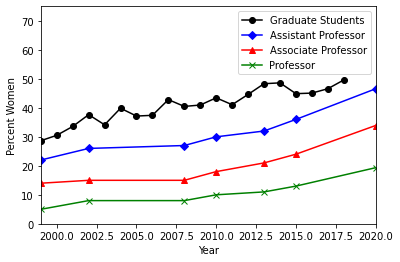

In [ ]:
# Put grad students in with the faculty
years = list(range(1981,2019))
years_data = [1999, 2002, 2008, 2010, 2013, 2015, 2020]


plt.plot(years, percent_gradstudents, 'ko-', label='Graduate Students')
plt.plot(years_data,percent_female_asstprof,'bD-', label='Assistant Professor')
plt.plot(years_data,percent_female_assocprof,'r^-', label='Associate Professor')
plt.plot(years_data, percent_female_prof,'gx-', label = 'Professor')
plt.legend();
#plt.grid()
plt.xlim([1999, 2020])
plt.ylim([0, 75])
plt.xlabel('Year');
plt.ylabel('Percent Women');


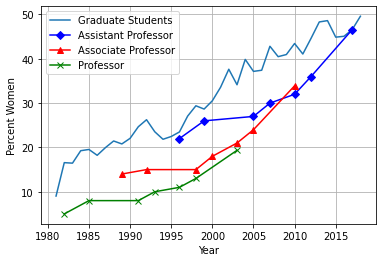

In [ ]:
# shift the faculty to when they were grad students

# on average, assistant professors are 3 years out from their phd, associate professors are 10 years out, full professors are 20 years out
years = list(range(1981,2019))
years_data = [1999, 2002, 2008, 2010, 2013, 2015, 2020]
years_asstprof = [1999-3,2002-3,2008-3,2010-3,2013-3,2015-3,2020-3]
years_assocprof = [1999-10,2002-10,2008-10,2010-10,2013-10,2015-10,2020-10]
years_prof = [1999-17,2002-17,2008-17,2010-17,2013-17,2015-17,2020-17]

plt.plot(years, percent_gradstudents, label='Graduate Students')
plt.plot(years_asstprof,percent_female_asstprof,'bD-', label='Assistant Professor')
plt.plot(years_assocprof,percent_female_assocprof,'r^-', label='Associate Professor')
plt.plot(years_prof, percent_female_prof,'gx-', label = 'Professor')
plt.legend();
plt.grid()
plt.xlabel('Year');
plt.ylabel('Percent Women');
plt.savefig('facultygradstudents_shifted.png')

In [ ]:
# compute the gradient of the percent of female geoscientists over the years

# check with others to see if we should be taking a gradient or just showing the difference...
# could take the slopes 

gradient_asstprof = np.gradient(percent_female_asstprof)/np.gradient(years)
gradient_assocprof = np.gradient(percent_female_assocprof)/np.gradient(years)
gradient_prof = np.gradient(percent_female_prof)/np.gradient(years)
gradient_total = np.gradient(percent_female_total)/np.gradient(years_total)

ValueError: ignored

In [ ]:
# plot the gradient of percent of femle geoscientists over years

years = [1999, 2002, 2008, 2010, 2013, 2015, 2020]

plt.plot(years, gradient_asstprof,'bD-', label='Assistant Professor')
plt.plot(years, gradient_assocprof,'r^-', label='Associate Professor')
plt.plot(years, gradient_prof,'gx-', label = 'Professor')
plt.plot(years_total,gradient_total,'ko-',label='Total')
plt.legend();
plt.grid()
plt.xlabel('Year');
plt.ylabel('Change in Percentage of Female Faculty');
plt.savefig('gradient_percentfemalefaculty_time.png')

In [ ]:
# compute change in percent of female geoscientists over the years

change_percent_female_asstprof = []
change_percent_female_assocprof = []
change_percent_female_prof = []
change_percent_female_total = []
for i in range(len(years)-1):
  change_percent_female_asstprof.append((percent_female_asstprof[i+1]-percent_female_asstprof[i])/(years[i+1]-years[i]))
  change_percent_female_assocprof.append((percent_female_assocprof[i+1]-percent_female_assocprof[i])/(years[i+1]-years[i]))
  change_percent_female_prof.append((percent_female_prof[i+1]-percent_female_prof[i])/(years[i+1]-years[i]))
  
for i in range(len(years_total)-1):
  change_percent_female_total.append((percent_female_total[i+1]-percent_female_total[i])/(years_total[i+1]-years_total[i]))


In [ ]:
# plot the change of percent of femle geoscientists over years

year_range = ['1999-2002', '2002-2008', '2008-2010', '2010-2013', '2013-2015', '2015-2020']
year_range_total = ['1999-2002','2002-2013','2013-2015','2015-2020']

plt.plot(year_range, change_percent_female_asstprof,'bD-', label='Assistant Professor')
plt.plot(year_range, change_percent_female_assocprof,'r^-', label='Associate Professor')
plt.plot(year_range, change_percent_female_prof,'gx-', label = 'Professor')
plt.legend();
plt.grid()
plt.xlabel('Year');
plt.ylabel('Change in Percentage of Female Faculty');
plt.savefig('change_percentfemalefaculty_time.png')


In [ ]:
plt.plot(year_range_total,change_percent_female_total,'k-',label = 'Total')
plt.legend();
plt.grid()
plt.xlabel('Year');
plt.ylabel('Change in Percentage of Female Faculty');

change_percent_female_total

# Percent of Female Geoscience Faculty by Subdiscipline

In [ ]:
# Compile the faculty in each subdiscipline

# the subdisciplines: Atmospheric Chemistry, Atmospheric Dynamics, Geology, Geophysics, Paleoclimate, Geochemistry, Geobiology, Chemical Oceanography, Biological Oceanography
# Physical Oceanography, Glaciology, Hydrology, Planetary Sciences, Climate Dynamics, GIS/Engineering, Geopolitics/Impacts, Sustainability, Resource Management
# Geomorphology, Ecology, Paleontology , Paleobiology, Land Surface Processes, Education, Marine Geology, Paleoceanography, Ocean Acoustics. Marine Biology, History of Science

atmoschem = df[df['Discipline'].str.contains("atmospheric chemistry")] # find all the atmospheric chemists in the dataset
atmosdyn = df[df['Discipline'].str.contains("atmospheric dynamics")] # find all the atmospheric dynamicists in the dataset
geology = df[df['Discipline'].str.contains("geology")] # find all the geologists in the dataset
geophysics = df[df['Discipline'].str.contains("geophysics")] # find all the geophysicists in the dataset
paleoclimate = df[df['Discipline'].str.contains("paleoclimate")] # find all the paleoclimatologists in the dataset
geochem = df[df['Discipline'].str.contains("geochemistry")] # find all the geochemists in the dataset
geobio = df[df['Discipline'].str.contains("geobiology")] # find all the geobiologists in the dataset
chemocean = df[df['Discipline'].str.contains("chemical oceanography")] # find all the chemical oceanographers in the dataset
bioocean = df[df['Discipline'].str.contains("biological oceanography")] # find all the biological oceanographers in the dataset
physocean = df[df['Discipline'].str.contains("physical oceanography")] # find all the physical oceanographers in the dataset
glaciology = df[df['Discipline'].str.contains("glaciology")] # find all the glaciologists in the dataset
hydrology = df[df['Discipline'].str.contains("hydrology")] # find all the hydrologists in the dataset
planetary = df[df['Discipline'].str.contains("planetary")] # find all the planetary scientists in the dataset
climatedyn = df[df['Discipline'].str.contains("climate dynamics")] # find all the climate dynamicists in the dataset
gisengin = df[df['Discipline'].str.contains("gis")] # find all the gis/engineers in the dataset
impacts = df[df['Discipline'].str.contains("impacts")] # find all the political scientists/impacts scientists in the dataset
sustain = df[df['Discipline'].str.contains("sustainability")] # find all the sustainability scientists in the dataset
resource = df[df['Discipline'].str.contains("resource management")] # find all the resource management scientists in the dataset
geomorph = df[df['Discipline'].str.contains("geomorphology")] # find all the geomorphologists in the dataset
ecology = df[df['Discipline'].str.contains("ecology")] # find all the ecologists in the dataset
paleontology = df[df['Discipline'].str.contains("paleontology")] # find all the paleontologists in the dataset
paleobio = df[df['Discipline'].str.contains("paleobiology")] # find all the paleobiologists in the dataset
land = df[df['Discipline'].str.contains("land surface")] # find all the land surface scientists in the dataset
education = df[df['Discipline'].str.contains("education")] # find all the education scientists in the dataset
marinegeo = df[df['Discipline'].str.contains("marine geology")] # find all the marine geologists in the dataset
paleocean = df[df['Discipline'].str.contains("paleoceanography")] # find all the paleoceanographers in the dataset
acoustics = df[df['Discipline'].str.contains("acoustics")] # find all the acoustics scientists in the dataset
marinebio = df[df['Discipline'].str.contains("marine biology")] # find all the marine biologists in the dataset
history = df[df['Discipline'].str.contains("history")] # find all the science historians in the dataset
biogeochemistry = df[df['Discipline'].str.contains("biogeochemistry")] # find all the science historians in the dataset


In [ ]:
# ignore subdisciplines with less than 10 people - only history of science
names = ['atmospheric chemistry','atmospheric dynamics',
         'geology','geophysics','paleoclimate','geochemistry',
         'geobiology','chemical oceanography','biological oceanography',
         'physical oceanography','glaciology','hydrology','planetary',
         'climate dynamics','gisengin','impacts','sustainability',
         'resource','geomorphology','ecology','paleontology','paleobiology',
         'land','education','marine geology','paleoceanography','ocean acoustics',
         'marine biology','history of science']
size = len(names)
num_fields = []
num_fields_small = []

i=1
for field in [atmoschem,atmosdyn,geology,geophysics,paleoclimate,
              geochem,geobio,chemocean,bioocean,physocean,glaciology,
              hydrology,planetary,climatedyn,gisengin,impacts,sustain,
              resource,geomorph,ecology,paleontology,paleobio,land,
              education,marinegeo,paleocean,acoustics,marinebio,history]:
  num_fields.append(field.count()['Name'])
  if field.count()['Name'] < 10:
    num_fields_small.append(names[i-1])
  i=i+1



In [ ]:
# Compute the percentage of women in each subdiscipline

# Atmospheric Chemistry
gender_atmoschem = atmoschem.groupby(['Gender']).count()['Name'] # look at their genders
percent_atmoschem = gender_atmoschem[0]/(gender_atmoschem[0]+gender_atmoschem[1])*100 # compute the percentage

# Atmospheric Dynamics
gender_atmosdyn = atmosdyn.groupby(['Gender']).count()['Name'] # look at their genders
percent_atmosdyn = gender_atmosdyn[0]/(gender_atmosdyn[0]+gender_atmosdyn[1])*100 # compute the percentage

# Geology
gender_geology = geology.groupby(['Gender']).count()['Name'] # look at their genders
percent_geology = gender_geology[0]/(gender_geology[0]+gender_geology[1])*100 # compute the percentage

# Geophysics
gender_geophysics = geophysics.groupby(['Gender']).count()['Name'] # look at their genders
percent_geophysics = gender_geophysics[0]/(gender_geophysics[0]+gender_geophysics[1])*100 # compute the percentage

# Paleoclimate
gender_paleoclimate = paleoclimate.groupby(['Gender']).count()['Name'] # look at their genders
percent_paleoclimate = gender_paleoclimate[0]/(gender_paleoclimate[0]+gender_paleoclimate[1])*100 # compute the percentage

# Geochemistry
gender_geochem = geochem.groupby(['Gender']).count()['Name'] # look at their genders
percent_geochem = gender_geochem[0]/(gender_geochem[0]+gender_geochem[1])*100 # compute the percentage

# Geobiology
gender_geobio = geobio.groupby(['Gender']).count()['Name'] # look at their genders
percent_geobio = gender_geobio[0]/(gender_geobio[0]+gender_geobio[1])*100 # compute the percentage

# Chemical Oceanography
gender_chemocean = chemocean.groupby(['Gender']).count()['Name'] # look at their genders
percent_chemocean = gender_chemocean[0]/(gender_chemocean[0]+gender_chemocean[1])*100 # compute the percentage

# Biological Oceanography
gender_bioocean = bioocean.groupby(['Gender']).count()['Name'] # look at their genders
percent_bioocean = gender_bioocean[0]/(gender_bioocean[0]+gender_bioocean[1])*100 # compute the percentage

# Physical Oceanography
gender_physocean = physocean.groupby(['Gender']).count()['Name'] # look at their genders
percent_physocean = gender_physocean[0]/(gender_physocean[0]+gender_physocean[1])*100 # compute the percentage

# Glaciology
gender_glaciology = glaciology.groupby(['Gender']).count()['Name'] # look at their genders
percent_glaciology = gender_glaciology[0]/(gender_glaciology[0]+gender_glaciology[1])*100 # compute the percentage

# Hydrology
gender_hydrology = hydrology.groupby(['Gender']).count()['Name'] # look at their genders
#percent_hydrology = gender_hydrology[1]/(gender_hydrology[1]+gender_hydrology[2])*100 # compute the percentage

# Planetary Science
gender_planetary = planetary.groupby(['Gender']).count()['Name'] # look at their genders
percent_planetary = gender_planetary[0]/(gender_planetary[0]+gender_planetary[1])*100 # compute the percentage

# Climate Dynamics
gender_climdyn = climatedyn.groupby(['Gender']).count()['Name'] # look at their genders
percent_climdyn = gender_climdyn[0]/(gender_climdyn[0]+gender_climdyn[1])*100 # compute the percentage

# GIS/Engineering
gender_gisengin = gisengin.groupby(['Gender']).count()['Name'] # look at their genders
percent_gisengin = gender_gisengin[0]/(gender_gisengin[0]+gender_gisengin[1])*100 # compute the percentage

# Impacts
gender_impacts = impacts.groupby(['Gender']).count()['Name'] # look at their genders
percent_impacts = gender_impacts[0]/(gender_impacts[0]+gender_impacts[1])*100 # compute the percentage

# Sustainability
gender_sustain = sustain.groupby(['Gender']).count()['Name'] # look at their genders
percent_sustain = gender_sustain[0]/(gender_sustain[0]+gender_sustain[1])*100 # compute the percentage

# Resource Management
gender_resource = resource.groupby(['Gender']).count()['Name'] # look at their genders
percent_resource = gender_resource[0]/(gender_resource[0]+gender_resource[1])*100 # compute the percentage

# Geomorphology
gender_geomorph = geomorph.groupby(['Gender']).count()['Name'] # look at their genders
percent_geomorph = gender_geomorph[0]/(gender_geomorph[0]+gender_geomorph[1])*100 # compute the percentage

# Ecology
gender_ecology = ecology.groupby(['Gender']).count()['Name'] # look at their genders
#percent_ecology = gender_ecology[1]/(gender_ecology[1]+gender_ecology[2])*100 # compute the percentage

# Paleontology
gender_paleontology = paleontology.groupby(['Gender']).count()['Name'] # look at their genders
percent_paleontology = gender_paleontology[0]/(gender_paleontology[0]+gender_paleontology[1])*100 # compute the percentage

# Paleobiology
gender_paleobio = paleobio.groupby(['Gender']).count()['Name'] # look at their genders
percent_paleobio = gender_paleobio[0]/(gender_paleobio[0]+gender_paleobio[1])*100 # compute the percentage

# Land Surface Processes
gender_land = land.groupby(['Gender']).count()['Name'] # look at their genders
percent_land = gender_land[0]/(gender_land[0]+gender_land[1])*100 # compute the percentage

# Education
gender_education = education.groupby(['Gender']).count()['Name'] # look at their genders
percent_education = gender_education[0]/(gender_education[0]+gender_education[1])*100 # compute the percentage

# Marine Geology
gender_marinegeo = marinegeo.groupby(['Gender']).count()['Name'] # look at their genders
percent_marinegeo = gender_marinegeo[0]/(gender_marinegeo[0]+gender_marinegeo[1])*100 # compute the percentage

# Paleoceanography
gender_paleocean = paleocean.groupby(['Gender']).count()['Name'] # look at their genders
percent_paleocean = gender_paleocean[0]/(gender_paleocean[0]+gender_paleocean[1])*100 # compute the percentage

# Ocean Acoustics
gender_acoustics = acoustics.groupby(['Gender']).count()['Name'] # look at their genders
percent_acoustics = gender_acoustics[0]/(gender_acoustics[0]+gender_acoustics[1])*100 # compute the percentage

# Marine Biology
gender_marinebio = marinebio.groupby(['Gender']).count()['Name'] # look at their genders
percent_marinebio = gender_marinebio[0]/(gender_marinebio[0]+gender_marinebio[1])*100 # compute the percentage

# History of Science
gender_history = history.groupby(['Gender']).count()['Name'] # look at their genders
percent_history = gender_history[0]/(gender_history[0]+gender_history[1])*100 # compute the percentage

# Biogeochemistry
gender_biogeochemistry = biogeochemistry.groupby(['Gender']).count()['Name'] # look at their genders
percent_biogeochemistry = gender_biogeochemistry[0]/(gender_biogeochemistry[0]+gender_biogeochemistry[1])*100 # compute the percentage


In [ ]:
# compute percentage of women in asst/assoc/prof ranks for each subdiscipline
all_subdisc = [atmoschem,atmosdyn,geology,geophysics,geochem,paleoclimate,geobio,chemocean,bioocean,physocean,planetary,biogeochemistry,glaciology,marinegeo,geomorph,paleocean]

test = planetary.groupby(['Gender','Career Stage']).count()['Name']
print(test)

In [ ]:
# Compute the percentage of women in earth, atmosphere, ocean

# subdisciplines not categorized: paleoclimate, hydrology, climate dynamics, gis/engineering, impacts, sustainability, resources, ecology, planeontology, paleobiology, land
# education

# of all the oceanographers, what percentage are women?
# Oceanography: Chemical Oceanography, Biological Oceanography, Physical Oceanography, Marine Biology, Paleoceanography, Ocean Acoustics
ocean = chemocean 
ocean = ocean.append([bioocean, physocean, marinebio, paleocean, acoustics])
gender_ocean = ocean.groupby(['Gender']).count()['Name'] # look at their genders
percent_ocean = gender_ocean[0]/(gender_ocean[0]+gender_ocean[1])*100 # compute the percentage

# of all the atmospheric scientists, what percentage are women?
# Atmosphere: Atmospheric Dynamics, Atmospheric Chemistry
atmosphere = atmoschem
atmosphere = atmosphere.append(atmosdyn)
gender_atmosphere = atmosphere.groupby(['Gender']).count()['Name'] # look at their genders
percent_atmosphere = gender_atmosphere[0]/(gender_atmosphere[0]+gender_atmosphere[1])*100 # compute the percentage

# of all the earth scientists, what percentage are women?
# Earth: Geology, Geophysics, Geochemistry, Geobiology, Geomorphology, Marine Geology, Glaciology, geochemistry, biogeochemistry
earth = geology
earth = earth.append([geophysics, geochem, geobio, geomorph, marinegeo, glaciology, geochem, biogeochemistry])
gender_earth = earth.groupby(['Gender']).count()['Name'] # look at their genders
percent_earth = gender_earth[0]/(gender_earth[0]+gender_earth[1])*100 # compute the percentage

# of all the planetary scientists, what percentage are women?
planets = planetary
gender_planets = planets.groupby(['Gender']).count()['Name'] # look at their genders
percent_planets = gender_planets[0]/(gender_planets[0]+gender_planets[1])*100 # compute the percentage


In [ ]:
# Make a Pie Chart of Earth, Atmosphere, Ocean

# pie chart
fig, ax = plt.subplots()
labels = 'Earth: F','Earth: M','Atmosphere: F','Atmosphere: M','Ocean: F','Ocean: M'
size = 0.3
vals = np.array([[percent_earth,100-percent_earth], [percent_atmosphere,100-percent_atmosphere], [percent_ocean,100-percent_ocean]]);
explode = (0.1,0.1, 0.1,0.1,0.1,0.1)

cmap = plt.get_cmap("tab20c")
outer_colors = cmap(np.arange(3)*4)
inner_colors = cmap(np.array([1, 2, 5, 6, 9, 10]))

ax.pie(vals.flatten(), explode=explode,labels=labels, autopct='%1.1f%%',shadow=True, radius=1.5, colors=inner_colors, 
       wedgeprops=dict(width=1, edgecolor='w'))

ax.set(aspect="equal")
plt.show()


In [ ]:
# Another possible pie chart
import matplotlib.colors as mcolors

# Make a Pie Chart of Earth, Atmosphere, Ocean

# pie chart
fig, ax = plt.subplots()
labels = 'Earth','Atmosphere','Ocean'
size = 0.5
vals = np.array([[percent_earth,100-percent_earth], [percent_atmosphere,100-percent_atmosphere], [percent_ocean,100-percent_ocean]]);
explode = [0,0,0,0,0,0]
outer_colors = ['darkorange','seagreen','mediumblue']
inner_colors = ['burlywood','bisque','forestgreen','palegreen','royalblue','lightblue']

ax.pie(vals.sum(axis=1), labels=labels, radius=1.5, colors=outer_colors,
       wedgeprops=dict(width=size, edgecolor='w'))

ax.pie(vals.flatten(), explode=explode, autopct='%1.1f%%',shadow=True, radius=1.5-size, colors=inner_colors, 
       wedgeprops=dict(width=size, edgecolor='w'))

ax.set(aspect="equal")
plt.show()


In [ ]:
# Compute the percentage of women in chemistry, biology, physics

# of all the biologists, what percentage are women?
# Biology: Geobiology, Marine Biology, Paleobiology, Biological Oceanography, Ecology
biology = geobio 
biology = biology.append([marinebio, paleobio, bioocean, ecology])
gender_biology = biology.groupby(['Gender']).count()['Name'] # look at their genders
percent_biology = gender_biology[0]/(gender_biology[0]+gender_biology[1])*100 # compute the percentage

# of all the chemists, what percentage are women?
# Chemistry: Geochemistry, Chemical Oceanography, Atmospheric Chemistry
chem = geochem 
chem = chem.append([chemocean, atmoschem])
gender_chem = chem.groupby(['Gender']).count()['Name'] # look at their genders
percent_chem = gender_chem[0]/(gender_chem[0]+gender_chem[1])*100 # compute the percentage

# of all the physicists, what percentage are women?
# Physics: Geophysics, Atmospheric Dynamics, Physical Oceanography
physics = geophysics 
physics = physics.append([atmosdyn, physocean])
gender_physics = physics.groupby(['Gender']).count()['Name'] # look at their genders
percent_physics = gender_physics[0]/(gender_physics[0]+gender_physics[1])*100 # compute the percentage


In [ ]:
# Make a Pie Chart of Chemistry, Physics, Biology
# except this makes no sense as a pie chart because they don't add up to 100....

# pie chart
labels = 'Chemistry','Biology','Physics'
sizes = [percent_chem, percent_biology, percent_physics];
explode = (0.1,0.1, 0.1)
fig, ax = plt.subplots()
ax.pie(sizes,explode=explode,labels=labels, colors=['green','orange','yellow'],autopct='%1.1f%%',shadow=True,startangle=90);
ax.axis('equal');

In [ ]:
# Prepare for the following pie chart...

# simplify ocean sciences
ocean_simp = chemocean 
ocean_simp = ocean_simp.append([bioocean, physocean, marinebio, paleocean])

# of oceanographers, what percentage are physical oceanographers?
wrk = physocean.count()/ocean_simp.count()*100
percent_physocean_ocean = wrk[1]

# of oceanographers, what percentage are biological oceanographers?
bioocean_tot = bioocean.append(marinebio)
wrk = bioocean_tot.count()/ocean_simp.count()*100
percent_bioocean_ocean = wrk[1]

# of oceanographers, what percentage are chemical oceanographers?
wrk = chemocean.count()/ocean_simp.count()*100
percent_chemocean_ocean = wrk[1]

# simplify earth sciences
earth_simp = geophysics
earth_simp = earth_simp.append([geochem, geobio, biogeochemistry, marinegeo, geomorph, glaciology, geology])

# of earth scientists, what percentage are geophysicists?
wrk = geophysics.count()/earth_simp.count()*100
percent_geophysics_earth = wrk[1]

# of earth scientists, what percentage are geobiologists?
wrk = geobio.count()/earth_simp.count()*100
percent_geobio_earth = wrk[1]

# of earth scientists, what percentage are geochemists?
wrk = geochem.count()/earth_simp.count()*100
percent_geochem_earth = wrk[1]

# of atmospheric scientists, what percentage are atmospheric chemists?
wrk = atmoschem.count()/atmosphere.count()*100
percent_atmoschem_atmos = wrk[1]

# of atmospheric scientists, what percentage are atmospheric dynamicists?
wrk = atmosdyn.count()/atmosphere.count()*100
percent_atmosdyn_atmos = wrk[1]

print(percent_geochem_earth)
print(percent_geophysics_earth)
print(percent_geobio_earth)

print(ocean_simp)

In [ ]:
# Try to put chem/bio/physics with ocean/atmosphere/earth in the same pie chart!
import matplotlib.colors as mcolors

# Things to talk about: (1) Does it make it hard to compare given that the chemistry/biology/physics sections are proportional 
# to the percentage of chem/bio/physics in each subdiscipline?  Should they take up the same space in the pie chart?
# (2) The inner pie chart includes ALL ocean/earth/atmos subdisciplines.  The outer pie chart cuts out some of the subdisciplines
# that don't fit neatly into "chem/bio/physics" (i.e. marine geology, geology, geomorphology, paleoceanography,...).  But the way 
# the pie chart is structured, it makes it seem like the same dataset is used in the inner and outer pie chart.

# pie chart
fig, ax = plt.subplots()
labels_outer = 'Chem-Earth','','Bio-Earth','','Physics-Earth','','Chem-Atmosphere','','','','Physics-Atmosphere','','Chem-Ocean','','Bio-Ocean','','Physics-Ocean',''
labels_inner = 'Earth','Earth','Atmosphere','Atmosphere','Ocean','Ocean'
size = 0.5

# define the values of the percentages 
vals = np.array([[percent_earth, 100-percent_earth], [percent_atmosphere,100-percent_atmosphere], [percent_ocean,100-percent_ocean]]);
vals2 = np.array([[percent_geochem_earth*percent_geochem,percent_geochem_earth*(100-percent_geochem)],[percent_geobio_earth*percent_geobio,percent_geobio_earth*(100-percent_geobio)],[percent_geophysics_earth*percent_geophysics,percent_geophysics_earth*(100-percent_geophysics)],[percent_atmoschem_atmos*percent_atmoschem,percent_atmoschem_atmos*(100-percent_atmoschem)],[0,0],[percent_atmosdyn_atmos*percent_atmosdyn,percent_atmosdyn_atmos*(100-percent_atmosdyn)],[percent_chemocean_ocean*percent_chemocean,percent_chemocean_ocean*(100-percent_chemocean)],[percent_bioocean_ocean*percent_bioocean,percent_bioocean_ocean*(100-percent_bioocean)],[percent_physocean_ocean*percent_physocean,percent_physocean_ocean*(100-percent_physocean)]]);

# go here to find the list of named colors you can use: https://matplotlib.org/3.1.1/gallery/color/named_colors.html
# I think I managed to make it look worse
# why is the atmosphere purple??  I don't know!!
outer_colors = ['chocolate','sandybrown','chocolate','sandybrown','chocolate','sandybrown','blueviolet','mediumpurple','blueviolet','mediumpurple','blueviolet','mediumpurple','cornflowerblue','lightsteelblue','cornflowerblue','lightsteelblue','cornflowerblue','lightsteelblue']
inner_colors = ['darkorange','bisque','purple','thistle','royalblue','lightblue']

# make the pie plots
ax.pie(vals2.flatten(), labels=labels_outer, radius=1.9, colors=outer_colors,
       wedgeprops=dict(width=size, edgecolor='w'),startangle=90)

ax.pie(vals.flatten(), labels=labels_inner, shadow=True, radius=1.9-size, colors=inner_colors, 
       wedgeprops=dict(width=size, edgecolor='w'),startangle=90)

ax.set(aspect="equal")
plt.show()


In [ ]:
# Prepare for the following pie chart...

# Oceanography: Chemical Oceanography, Biological Oceanography, Physical Oceanography, Marine Biology, Paleoceanography, Ocean Acoustics
# Atmosphere: Atmospheric Dynamics, Atmospheric Chemistry
# Earth: Geology, Geophysics, Geochemistry, Geobiology, Geomorphology, Marine Geology, Glaciology, biogeochemistry

# of oceanographers, what percentage are physical oceanographers?
wrk = physocean.count()/ocean.count()*100
percent_physocean_ocean = wrk[1]

# of oceanographers, what percentage are biological oceanographers?
bioocean_tot = bioocean.append(marinebio)
wrk = bioocean_tot.count()/ocean.count()*100
percent_bioocean_ocean = wrk[1]

# of oceanographers, what percentage are chemical oceanographers?
wrk = chemocean.count()/ocean.count()*100
percent_chemocean_ocean = wrk[1]

# of oceanographers, what percentage are paleoceanographers?
wrk = paleocean.count()/ocean.count()*100
percent_paleocean_ocean = wrk[1]

# of oceanographers, what percentage are marine biologists?
wrk = marinebio.count()/ocean.count()*100
percent_marinebio_ocean = wrk[1]

# of oceanographers, what percentage are ocean acoustics?
wrk = acoustics.count()/ocean.count()*100
percent_acoustics_ocean = wrk[1]

# of earth scientists, what percentage are geophysicists?
wrk = geophysics.count()/earth.count()*100
percent_geophysics_earth = wrk[1]

# of earth scientists, what percentage are geobiologists?
wrk = geobio.count()/earth.count()*100
percent_geobio_earth = wrk[1]

# of earth scientists, what percentage are geochemists?
wrk = geochem.count()/earth.count()*100
percent_geochem_earth = wrk[1]

# of earth scientists, what percentage are glaciologists?
wrk = glaciology.count()/earth.count()*100
percent_glaciology_earth = wrk[1]

# of earth scientists, what percentage are geomorphologists?
wrk = geomorph.count()/earth.count()*100
percent_geomorph_earth = wrk[1]

# of earth scientists, what percentage are geologists?
wrk = geology.count()/earth.count()*100
percent_geology_earth = wrk[1]

# of earth scientists, what percentage are marine geologists?
wrk = marinegeo.count()/earth.count()*100
percent_marinegeo_earth = wrk[1]

# of earth scientists, what percentage are biogeochemists?
wrk = biogeochemistry.count()/earth.count()*100
percent_biogeochemistry_earth = wrk[1]


# of atmospheric scientists, what percentage are atmospheric chemists?
wrk = atmoschem.count()/atmosphere.count()*100
percent_atmoschem_atmos = wrk[1]

# of atmospheric scientists, what percentage are atmospheric dynamicists?
wrk = atmosdyn.count()/atmosphere.count()*100
percent_atmosdyn_atmos = wrk[1]

print(planetary.count)

In [ ]:
# Pie charts x bar charts

import matplotlib.colors as mcolors

# Make Pie Charts of Earth, Atmosphere, Ocean, Planetary

# pie chart
fig, axs = plt.subplots(2,2)
fig.subplots_adjust(0.6,0,2,2,1)

# Earth Pie Chart
labels = 'Geophysics','Geobiology','Glaciology','Geomorphology','Marine Geology','Geology', 'Geochemisry', 'Biogeochemistry'
size = 0.5
vals_inner = np.array([[percent_earth,100-percent_earth]]);
vals_outer = np.array([[percent_geophysics_earth, percent_geobio_earth, percent_glaciology_earth, percent_geomorph_earth, percent_marinegeo_earth, percent_geology_earth, percent_geochem_earth, percent_biogeochemistry_earth]]) # percent of geologists, geophysicists, glaciologists, etc.
explode = [0,0,0,0,0,0]
inner_colors = ['burlywood','bisque']
outer_colors = ['chocolate','saddlebrown','peachpuff','peru','tan','linen', 'peru', 'peachpuff']
axs[0,0].pie(vals_outer.flatten(), labels=labels, radius=1.5, colors=outer_colors,shadow=True, 
       wedgeprops=dict(width=size, edgecolor='w'))
axs[0,0].pie(vals_inner.flatten(), shadow=True, radius=1.5-size, colors=inner_colors, autopct='%1.1f%%',
       wedgeprops=dict(width=size, edgecolor='w'))
axs[0,0].set(aspect="equal")

# Ocean Pie Chart
labels = 'Chemical Oceanography','Biological Oceanography','Physical Oceanography','Marine Biology','Paleoceanography','Ocean Acoustics'
size = 0.5
vals_inner = np.array([[percent_ocean,100-percent_ocean]]);
vals_outer = np.array([[percent_chemocean_ocean, percent_bioocean_ocean, percent_physocean_ocean, percent_marinebio_ocean, percent_paleocean_ocean, percent_acoustics_ocean]]) 
explode = [0,0,0,0,0,0]
inner_colors = ['royalblue','lightblue']
outer_colors = ['cadetblue','powderblue','deepskyblue','steelblue','cornflowerblue','lavender']
axs[0,1].pie(vals_outer.flatten(), labels=labels, radius=1.5, colors=outer_colors,shadow=True, 
       wedgeprops=dict(width=size, edgecolor='w'))
axs[0,1].pie(vals_inner.flatten(), shadow=True, radius=1.5-size, colors=inner_colors, autopct='%1.1f%%',
       wedgeprops=dict(width=size, edgecolor='w'))
axs[0,1].set(aspect="equal")

# Atmosphere Pie Chart
labels = 'Atmospheric Dynamics','Atmospheric Chemistry'
size = 0.5
vals_inner = np.array([[percent_atmosphere,100-percent_atmosphere]]);
vals_outer = np.array([[percent_atmoschem_atmos, percent_atmosdyn_atmos]]) 
explode = [0,0,0,0,0,0]
inner_colors = ['forestgreen','palegreen',]
outer_colors = ['turquoise','honeydew']
axs[1,0].pie(vals_outer.flatten(), labels=labels, radius=1.5, colors=outer_colors,shadow=True, 
       wedgeprops=dict(width=size, edgecolor='w'))
axs[1,0].pie(vals_inner.flatten(), shadow=True, radius=1.5-size, colors=inner_colors, autopct='%1.1f%%',
       wedgeprops=dict(width=size, edgecolor='w'))
axs[1,0].set(aspect="equal")

# Planets Pie Chart
size = 0.5
vals_inner = np.array([[percent_planets,100-percent_planets]]);
explode = [0,0,0,0,0,0]
inner_colors = ['darkorchid','thistle']
axs[1,1].pie(vals_inner.flatten(), shadow=True, radius=1.5-size, colors=inner_colors, autopct='%1.1f%%',
       wedgeprops=dict(width=size, edgecolor='w'))
axs[1,1].set(aspect="equal")

#plt.show()
#extent = axs.get_window_extent()
fig.savefig('percent_subdisciplines2.png',bbox_inches="tight")

print(percent_earth)


In [ ]:
# bar graphs to go with above
import matplotlib.colors as mcolors

# Make bar Charts of Earth, Atmosphere, Ocean, Planetary

# Earth bar Chart
fig1, axs1 = plt.subplots(2,3)
fig1.subplots_adjust(0.3,0,1.5,1.5,0.5)
axs1[0,0].bar(('Male','Female'),[100-percent_geophysics,percent_geophysics],color=['chocolate','chocolate'])
axs1[0,0].set_title('Geophysics')
axs1[0,0].set_ylim([0, 100])
axs1[0,1].bar(('Male','Female'),[100-percent_geobio,percent_geobio],color=['saddlebrown','saddlebrown'])
axs1[0,1].set_title('Geobiology')
axs1[0,1].set_ylim([0, 100])
axs1[0,2].bar(('Male','Female'),[100-percent_glaciology,percent_glaciology],color=['peachpuff','peachpuff'])
axs1[0,2].set_title('Glaciology')
axs1[0,2].set_ylim([0, 100])
axs1[1,0].bar(('Male','Female'),[100-percent_geomorph,percent_geomorph],color=['peru','peru'])
axs1[1,0].set_title('Geomorphology')
axs1[1,0].set_ylim([0, 100])
#axs1[1,1].bar(('Male','Female'),[100-percent_marinegeo,percent_marinegeo],color=['tan','tan'])
#axs1[1,1].set_title('Marine Geology')
#axs1[1,1].set_ylim([0, 100])
#axs1[1,2].bar(('Male','Female'),[100-percent_geology,percent_geology],color=['linen','linen'])
#axs1[1,2].set_title('Geology')
#axs1[1,2].set_ylim([0, 100])

axs1[1,1].bar(('Male','Female'),[100-percent_geochem,percent_geochem],color=['tan','tan'])
axs1[1,1].set_title('Geochemsitry')
axs1[1,1].set_ylim([0, 100])
axs1[1,2].bar(('Male','Female'),[100-percent_biogeochemistry,percent_biogeochemistry],color=['linen','linen'])
axs1[1,2].set_title('biogeochemistry')
axs1[1,2].set_ylim([0, 100])
plt.show()

# Ocean bar Chart
fig2, axs2 = plt.subplots(2,3)
fig2.subplots_adjust(0.3,0,1.5,1.5,0.5)
axs2[0,0].bar(('Male','Female'),[100-percent_chemocean,percent_chemocean],color=['cadetblue','cadetblue'])
axs2[0,0].set_title('Chemical Oceanography')
axs2[0,0].set_ylim([0, 100])
axs2[0,1].bar(('Male','Female'),[100-percent_bioocean,percent_bioocean],color=['powderblue','powderblue'])
axs2[0,1].set_title('Biological Oceanography')
axs2[0,2].set_ylim([0, 100])
axs2[0,2].bar(('Male','Female'),[100-percent_physocean,percent_physocean],color=['deepskyblue','deepskyblue'])
axs2[0,2].set_title('Physical Oceanography')
axs2[0,2].set_ylim([0, 100])
axs2[1,0].bar(('Male','Female'),[100-percent_marinebio,percent_marinebio],color=['steelblue','steelblue'])
axs2[1,0].set_title('Marine Biology')
axs2[1,0].set_ylim([0, 100])
axs2[1,1].bar(('Male','Female'),[100-percent_paleocean,percent_paleocean],color=['cornflowerblue','cornflowerblue'])
axs2[1,1].set_title('Paleoceanography')
axs2[1,1].set_ylim([0, 100])
axs2[1,2].bar(('Male','Female'),[100-percent_acoustics,percent_acoustics],color=['lavender','lavender'])
axs2[1,2].set_title('Ocean Acoustics')
axs2[1,2].set_ylim([0, 100])
plt.show()

# Atmosphere bar Chart
fig3, axs3 = plt.subplots(1,2)
fig3.subplots_adjust(0.1,0,1,1,0.5)
labels = 'Atmospheric Dynamics','Atmospheric Chemistry'
inner_colors = ['forestgreen','palegreen',]
outer_colors = ['turquoise','honeydew']
axs3[0].bar(('Male','Female'),[100-percent_atmosdyn,percent_atmosdyn],color=['turquoise','turquoise'])
axs3[0].set_title('Atmospheric Dynamics')
axs3[0].set_ylim([0, 100])
axs3[1].bar(('Male','Female'),[100-percent_atmoschem,percent_atmoschem],color=['palegreen','palegreen'])
axs3[1].set_title('Atmospheric Chemistry')
axs3[1].set_ylim([0, 100])
plt.show()




# Private Public University Split

In [ ]:
import statsmodels as sm

public_stats = (df.loc[(df['private_public'] == 'public') & (df['Gender'] == 'f')].groupby(['University','Career Stage']).count()['Name'])/(
    (df.loc[(df['private_public'] == 'public') & (df['Gender'] == 'f')].groupby(['University','Career Stage']).count()['Name']) +
    (df.loc[(df['private_public'] == 'public') & (df['Gender'] == 'm')].groupby(['University','Career Stage']).count()['Name'])
)
private_stats = (df.loc[(df['private_public'] == 'private') & (df['Gender'] == 'f')].groupby(['University','Career Stage']).count()['Name'])/(
    (df.loc[(df['private_public'] == 'private') & (df['Gender'] == 'f')].groupby(['University','Career Stage']).count()['Name']) +
    (df.loc[(df['private_public'] == 'private') & (df['Gender'] == 'm')].groupby(['University','Career Stage']).count()['Name'])
)

In [ ]:
sm.stats.weightstats.ztest(
    (private_stats.iloc[private_stats.index.get_level_values('Career Stage') == 'assistant professor']).dropna(),
    (public_stats.iloc[public_stats.index.get_level_values('Career Stage') == 'assistant professor']).dropna(), 
    value = 0, 
    alternative= 'two-sided'
    )

In [ ]:
sm.stats.weightstats.ztest(
    (private_stats.iloc[private_stats.index.get_level_values('Career Stage') == 'associate professor']).dropna(),
    (public_stats.iloc[public_stats.index.get_level_values('Career Stage') == 'associate professor']).dropna(), 
    value = 0, 
    alternative= 'two-sided'
    )

In [ ]:
sm.stats.weightstats.ztest(
    (private_stats.iloc[private_stats.index.get_level_values('Career Stage') == 'professor']).dropna(),
    (public_stats.iloc[public_stats.index.get_level_values('Career Stage') == 'professor']).dropna(), 
    value = 0, 
    alternative= 'two-sided'
    )

In [ ]:
fig, ax = plt.subplots(figsize =(5,5))
for pp in ['private','public']:
  # Data to plot
  labels = list(df.loc[df['private_public'] == pp].groupby(['Career Stage']).count()['Name'].index)
  sizes = list(df.loc[df['private_public'] == pp].groupby(['Career Stage']).count()['Name'].values)
  labels_gender = df.loc[df['private_public'] == pp].groupby(['Career Stage','Gender']).count().index.get_level_values(1)
  sizes_gender = df.loc[df['private_public'] == pp].groupby(['Career Stage','Gender']).count()['Name'].values
  colors = prof_colors.values()
  colors_gender = gender_colors.values()
  #explode = (0.2,0.2,0.2) 
  explode_gender = np.empty(len(labels_gender))
  explode_gender.fill(0.1)
  #Plot

  plt.pie(sizes, labels=labels, colors = colors, startangle=90,frame=True,radius=3.5)
  plt.pie(sizes_gender, colors = colors_gender, explode = explode_gender, startangle=90,radius=2.5 )
  #Draw circle
  center_circle = plt.Circle((0,0),2,color='black', fc='white',linewidth=0)
  fig = plt.gcf()
  fig.gca().add_artist(center_circle)
  
  plt.axis('equal')
  plt.title(pp)
  plt.tight_layout()
  plt.show()
  print(labels_gender)
  print(sizes_gender)
  print(sizes_gender[0]/sizes[0], sizes_gender[2]/sizes[1], sizes_gender[4]/sizes[2])
  print(labels)
  print(sizes)

In [ ]:
fig, ax = plt.subplots(figsize =(5,5))
for pp in ['private','public']:
  # Data to plot
  labels = list(df.loc[df['private_public'] == pp].groupby(['EPAO']).count()['Name'].index)
  sizes = list(df.loc[df['private_public'] == pp].groupby(['EPAO']).count()['Name'].values)
  labels_gender = df.loc[df['private_public'] == pp].groupby(['EPAO','Gender']).count().index.get_level_values(1)
  sizes_gender = df.loc[df['private_public'] == pp].groupby(['EPAO','Gender']).count()['Name'].values
  colors = ['forestgreen', 'darkgoldenrod', 'lightblue', 'mediumslateblue']
  colors_gender = gender_colors.values()
  explode = np.empty(len(labels)) 
  explode.fill(0.2) 
  explode_gender = np.empty(len(labels_gender))
  explode_gender.fill(0.1)

  #Plot

  plt.pie(sizes, labels=labels, colors = colors, explode = explode, startangle=90,frame=True,radius=3.5)
  plt.pie(sizes_gender, colors = colors_gender, explode = explode_gender, startangle=90,radius=2.5 )
  #Draw circle
  center_circle = plt.Circle((0,0),2,color='black', fc='white',linewidth=0)
  fig = plt.gcf()
  fig.gca().add_artist(center_circle)
  
  plt.axis('equal')
  plt.title(pp)
  plt.tight_layout()
  plt.show()
  print(labels_gender)
  print(sizes_gender)
  print(sizes_gender[0]/sizes[0], sizes_gender[2]/sizes[1], sizes_gender[4]/sizes[2], sizes_gender[6]/sizes[3])
  print(labels)
  print(sizes)

# Department Leadership

In [ ]:
gender_chair = dfc.groupby(['Gender']).count()['Name']
percent_chair = gender_chair[0]/(gender_chair[0]+gender_chair[1])*100


# bar chart
N = 2
ind = np.arange(N)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.grid(zorder=0)
ax.bar(('Female','Male'),[percent_chair,100-percent_chair],color=['green','orange'],zorder=3);
plt.ylabel('Percenatage of All Department Heads');



# pie chart
labels = 'Female','Male'
sizes = [percent_chair,100-percent_chair];
explode = (0.1,0.1)
fig, ax = plt.subplots()
ax.pie(sizes,explode=explode,labels=labels, colors=['green','orange'],autopct='%1.1f%%',shadow=True);
ax.axis('equal');
plt.savefig('percent_deptheads.png')






In [ ]:
percent_chair_F = len(df.loc[df['dept_head_gender'] == 'F'].groupby('University').count()['dept_head_gender'])/(
                              len(df.loc[df['dept_head_gender'] == 'F'].groupby('University').count()['dept_head_gender']) + 
                              len(df.loc[df['dept_head_gender'] == 'M'].groupby('University').count()['dept_head_gender']))*100
percent_chair_M = len(df.loc[df['dept_head_gender'] == 'M'].groupby('University').count()['dept_head_gender'])/(
                              len(df.loc[df['dept_head_gender'] == 'F'].groupby('University').count()['dept_head_gender']) + 
                              len(df.loc[df['dept_head_gender'] == 'M'].groupby('University').count()['dept_head_gender']))*100

In [ ]:
# bar chart
N = 2
ind = np.arange(N)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.grid(zorder=0)
ax.bar(('Female','Male'),[percent_chair_F,percent_chair_M],color=[dict_colors['female'],dict_colors['male']],zorder=3);
plt.ylabel('Percenatage of All Department Heads');


In [ ]:
# pie chart
labels = 'Female','Male'
sizes = [percent_chair_F,percent_chair_M];
explode = (0.1,0.1)
fig, ax = plt.subplots()
ax.pie(sizes,explode=explode,labels=labels, colors=[dict_colors['female'],dict_colors['male']],autopct='%1.1f%%',shadow=True);
ax.axis('equal');
plt.savefig('percent_deptheads.png')

In [ ]:
df.loc[(df['dept_head_gender'] == 'F')].loc[(df['Gender'] == 'F')].groupby('Career Stage').count()['Name'].plot.bar()

In [ ]:
df.loc[(df['dept_head_gender'] == 'M')].loc[(df['Gender'] == 'F')].groupby('Career Stage').count()['Name'].plot.bar()

In [ ]:
# Of all the departments with female department heads, what is the percentage of female faculty?  

# first find the departments with female department heads
female_heads = dfc.loc[dfc['Gender'] == 'F'] # find all entries with female department heads
num_female_heads = female_heads.count()['Name']
indexes = female_heads.index
female_heads.loc[:,"University"] = female_heads["University"].astype(str);
female_heads.loc[:,"Department"] = female_heads["Department"].astype(str);

femalehead_asstprof = pd.DataFrame();
femalehead_assocprof = pd.DataFrame();
femalehead_prof = pd.DataFrame();


percent_femalehead = []
for i in range(num_female_heads):
  # find the department and school in the big dataframe (df)
  univ = female_heads.loc[indexes[i]]['University']
  dept = female_heads.loc[indexes[i]]['Department']
  # pull faculty from that department and university
  faculty = df.loc[(df['University'] == univ) & (df['Department'] == dept)]
  # find percentage of women from that department
  gender = faculty.groupby(['Gender']).count()['Name']
  print(gender)
  if len(gender) == 1:
    percent_femalehead.append(0)
  elif len(gender) == 3:
    percent_femalehead.append(gender[1]/(gender[1]+gender[2])*100)
  else:
    percent_femalehead.append(gender[0]/(gender[0]+gender[1])*100)
  
  # compute percent by rank
  femalehead_asstprof = femalehead_asstprof.append(faculty.loc[faculty['Career Stage'] == 'assistant professor'])
  femalehead_assocprof = femalehead_assocprof.append(faculty.loc[faculty['Career Stage'] == 'associate professor'])
  femalehead_prof = femalehead_prof.append(faculty.loc[faculty['Career Stage'] == 'professor'])
  break

avg_percent_femalehead = np.average(percent_femalehead)
std_percent_femalehead = np.std(percent_femalehead)



In [ ]:
# Of the departments with male department heads, what is the percentage of female faculty?

# first find the departments with male department heads
male_heads = dfc.loc[dfc['Gender'] == 'M'] # find all entries with female department heads
num_male_heads = male_heads.count()['Name']
indexes = male_heads.index
male_heads["University"] = male_heads["University"].astype(str);
male_heads["Department"] = male_heads["Department"].astype(str);

malehead_asstprof = pd.DataFrame();
malehead_assocprof = pd.DataFrame();
malehead_prof = pd.DataFrame();

percent_malehead = []
for i in range(num_male_heads):
  # find the department and school in the big dataframe (df)
  univ = male_heads.loc[indexes[i]]['University']
  dept = male_heads.loc[indexes[i]]['Department']

  # pull faculty from that department and university
  faculty = df.loc[(df['University'] == univ) & (df['Department'] == dept)]

  # find percentage of women from that department
  gender = faculty.groupby(['Gender']).count()['Name']
  if len(gender) == 1:
    percent_malehead.append(0)
  elif len(gender) == 3:
    percent_malehead.append(gender[1]/(gender[1]+gender[2])*100)
  else:
    percent_malehead.append(gender[0]/(gender[0]+gender[1])*100)

  # compute percent by rank
  malehead_asstprof = malehead_asstprof.append(faculty.loc[faculty['Career Stage'] == 'assistant professor'])
  malehead_assocprof = malehead_assocprof.append(faculty.loc[faculty['Career Stage'] == 'associate professor'])
  malehead_prof = malehead_prof.append(faculty.loc[faculty['Career Stage'] == 'professor'])
  
avg_percent_malehead = np.average(percent_malehead)
std_percent_malehead = np.std(percent_malehead)

In [ ]:
# Plot Percent Women in Departments with Female Department Heads
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.grid(zorder=0)
#ax.hist(percent_femalehead, zorder=3);
ax.hist(percent_femalehead,[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50], zorder=3);
plt.ylabel('Number of Departments');
plt.xlabel('Percentage of Female Faculty');
plt.xlim((0, 50));

In [ ]:
# Plot Percent Women in Departments with Female Department Heads

N = num_female_heads
ind = np.arange(N)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.grid(zorder=0)
#ax.hist(percent_femalehead, zorder=3);
ax.hist(percent_femalehead,[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50], zorder=3);
plt.ylabel('Number of Departments');
plt.xlabel('Percentage of Female Faculty');
plt.xlim((0, 50));

In [ ]:
# Plot Percent Women in Departments with Male Department Heads

N = num_male_heads
ind = np.arange(N)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.grid(zorder=0)
#ax.hist(percent_malehead, zorder=3);
ax.hist(percent_malehead,[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50], zorder=3);
plt.ylabel('Number of Departments');
plt.xlabel('Percentage of Female Faculty');
plt.xlim((0, 50));

In [ ]:
# Conduct a Z-test of the two distributions to determine if they are statistically different
# Spoiler: they aren't.

Z = (avg_percent_femalehead-avg_percent_malehead)/np.sqrt((std_percent_femalehead/np.sqrt(num_female_heads))**2+(std_percent_malehead/np.sqrt(num_male_heads))**2)
Z

In [ ]:
# rank for female heads
asstprof_gender = femalehead_asstprof.groupby('Gender').count()['Name']
percent_asstprof_femalehead = asstprof_gender[0]/(asstprof_gender[0]+asstprof_gender[1])*100

assocprof_gender = femalehead_assocprof.groupby('Gender').count()['Name']
percent_assocprof_femalehead = assocprof_gender[0]/(assocprof_gender[0]+assocprof_gender[1])*100

prof_gender = femalehead_prof.groupby('Gender').count()['Name']
percent_prof_femalehead = prof_gender[0]/(prof_gender[0]+prof_gender[1])*100

# rank for male heads
asstprof_gender = malehead_asstprof.groupby('Gender').count()['Name']
percent_asstprof_malehead = asstprof_gender[0]/(asstprof_gender[0]+asstprof_gender[1])*100
percent_asstprof_malehead

assocprof_gender = malehead_assocprof.groupby('Gender').count()['Name']
percent_assocprof_malehead = assocprof_gender[1]/(assocprof_gender[1]+assocprof_gender[2])*100

prof_gender = malehead_prof.groupby('Gender').count()['Name']
percent_prof_malehead = prof_gender[0]/(prof_gender[0]+prof_gender[1])*100


In [ ]:
# plots for rank for female heads/male heads
fig, axs = plt.subplots(3,2)
fig.subplots_adjust(0.6,0,2,2)
# pie chart
labels = 'Female','Male'
sizes = [percent_asstprof_femalehead,100-percent_asstprof_femalehead];
explode = (0.1,0.1)
axs[0,0].pie(sizes,explode=explode,labels=labels, colors=['green','orange'],autopct='%1.1f%%',shadow=True);
axs[0,0].axis('equal');
axs[0,0].set_title('Assistant Professors');

labels = 'Female','Male'
sizes = [percent_assocprof_femalehead,100-percent_assocprof_femalehead];
explode = (0.1,0.1)
axs[1,0].pie(sizes,explode=explode, colors=['green','orange'],autopct='%1.1f%%',shadow=True);
axs[1,0].axis('equal');
axs[1,0].set_title('Associate Professors');

labels = 'Female','Male'
sizes = [percent_prof_femalehead,100-percent_prof_femalehead];
explode = (0.1,0.1)
axs[2,0].pie(sizes,explode=explode, colors=['green','orange'],autopct='%1.1f%%',shadow=True);
axs[2,0].axis('equal');
axs[2,0].set_title('Professors');

# pie chart
labels = 'Female','Male'
sizes = [percent_asstprof_malehead,100-percent_asstprof_malehead];
explode = (0.1,0.1)
axs[0,1].pie(sizes,explode=explode, colors=['green','orange'],autopct='%1.1f%%',shadow=True);
axs[0,1].axis('equal');
axs[0,1].set_title('Assistant Professors');

labels = 'Female','Male'
sizes = [percent_assocprof_malehead,100-percent_assocprof_malehead];
explode = (0.1,0.1)
axs[1,1].pie(sizes,explode=explode, colors=['green','orange'],autopct='%1.1f%%',shadow=True);
axs[1,1].axis('equal');
axs[1,1].set_title('Associate Professors');

labels = 'Female','Male'
sizes = [percent_prof_malehead,100-percent_prof_malehead];
explode = (0.1,0.1)
axs[2,1].pie(sizes,explode=explode, colors=['green','orange'],autopct='%1.1f%%',shadow=True);
axs[2,1].axis('equal');
axs[2,1].set_title('Professors');


Correlation between ranks

In [ ]:
pd.read_excel('NSF_data/data/grad_institution_demographics.xlsx')

In [ ]:
import os

In [ ]:
os.listdir()

# Hiring Model

In [ ]:
# find the percent of hires that are women assuming the time to tenure is 7 years

from scipy.interpolate import interp1d

years_sparse = [1999, 2002, 2008, 2010, 2013, 2015, 2020];
years = list(range(1999,2021))
f1 = interp1d(years_sparse,percent_female_asstprof);
percent_asst_interp = f1(years) 

for i in range(7):
  percent_asst_interp = np.insert(percent_asst_interp,0,22)

num_asst = 505
yearly_hire = 70

num_women = percent_asst_interp*num_asst/100
num_men = (100-percent_asst_interp)*num_asst/100

delta_women = []
delta_men = []
for i in range(len(num_women)-1):
  delta_women.append(num_women[i+1]-num_women[i])
  delta_men.append(num_men[i+1]-num_men[i])
delta_women.insert(0,0)
delta_men.insert(0,0)

num_women_hired = [0]*len(delta_women)
num_men_hired = [0]*len(delta_men)
for i in range(8):
  num_women_hired[i] = 15.4
  num_men_hired[i] = 54.6

num_women_hired = np.array(num_women_hired)
num_men_hired = np.array(num_men_hired)
for i in range(8,29):
  num_women_hired[i] = delta_women[i]+num_women_hired[i-7]
  num_men_hired[i] = delta_men[i]+num_men_hired[i-7]

percent_women_hired_7 = num_women_hired/(num_women_hired+num_men_hired)


In [ ]:
# find the percent of hires that are women assuming the time to tenure is 5 years

from scipy.interpolate import interp1d

years_sparse = [1999, 2002, 2008, 2010, 2013, 2015, 2020];
years = list(range(1999,2021))
f1 = interp1d(years_sparse,percent_female_asstprof);
percent_asst_interp = f1(years) 

for i in range(5):#6
  percent_asst_interp = np.insert(percent_asst_interp,0,22)

num_asst = 505
yearly_hire = 70

num_women = percent_asst_interp*num_asst/100
num_men = (100-percent_asst_interp)*num_asst/100

delta_women = []
delta_men = []
for i in range(len(num_women)-1):
  delta_women.append(num_women[i+1]-num_women[i])
  delta_men.append(num_men[i+1]-num_men[i])
delta_women.insert(0,0)
delta_men.insert(0,0)

num_women_hired = [0]*len(delta_women)
num_men_hired = [0]*len(delta_men)
for i in range(6):#7
  num_women_hired[i] = 15.4
  num_men_hired[i] = 54.6

num_women_hired = np.array(num_women_hired)
num_men_hired = np.array(num_men_hired)
for i in range(6,27):#7,28
  num_women_hired[i] = delta_women[i]+num_women_hired[i-5]#6
  num_men_hired[i] = delta_men[i]+num_men_hired[i-5]#6

percent_women_hired_5 = num_women_hired/(num_women_hired+num_men_hired)

# find the percent of hires that are women assuming the time to tenure is 6 years

from scipy.interpolate import interp1d

years_sparse = [1999, 2002, 2008, 2010, 2013, 2015, 2020];
years = list(range(1999,2021))
f1 = interp1d(years_sparse,percent_female_asstprof);
percent_asst_interp = f1(years) 

for i in range(6):#6
  percent_asst_interp = np.insert(percent_asst_interp,0,22)

num_asst = 505
yearly_hire = 70

num_women = percent_asst_interp*num_asst/100
num_men = (100-percent_asst_interp)*num_asst/100

delta_women = []
delta_men = []
for i in range(len(num_women)-1):
  delta_women.append(num_women[i+1]-num_women[i])
  delta_men.append(num_men[i+1]-num_men[i])
delta_women.insert(0,0)
delta_men.insert(0,0)

num_women_hired = [0]*len(delta_women)
num_men_hired = [0]*len(delta_men)
for i in range(7):#7
  num_women_hired[i] = 15.4
  num_men_hired[i] = 54.6

num_women_hired = np.array(num_women_hired)
num_men_hired = np.array(num_men_hired)
for i in range(7,28):#7,28
  num_women_hired[i] = delta_women[i]+num_women_hired[i-6]#6
  num_men_hired[i] = delta_men[i]+num_men_hired[i-6]#6

percent_women_hired_6 = num_women_hired/(num_women_hired+num_men_hired)


In [ ]:
# find the percent of hires that are women assuming the time to tenure is 8 years

from scipy.interpolate import interp1d

years_sparse = [1999, 2002, 2008, 2010, 2013, 2015, 2020];
years = list(range(1999,2021))
f1 = interp1d(years_sparse,percent_female_asstprof);
percent_asst_interp = f1(years) 

for i in range(8):#8
  percent_asst_interp = np.insert(percent_asst_interp,0,22)

num_asst = 505
yearly_hire = 70

num_women = percent_asst_interp*num_asst/100
num_men = (100-percent_asst_interp)*num_asst/100

delta_women = []
delta_men = []
for i in range(len(num_women)-1):
  delta_women.append(num_women[i+1]-num_women[i])
  delta_men.append(num_men[i+1]-num_men[i])
delta_women.insert(0,0)
delta_men.insert(0,0)

num_women_hired = [0]*len(delta_women)
num_men_hired = [0]*len(delta_men)
for i in range(9):#9
  num_women_hired[i] = 15.4
  num_men_hired[i] = 54.6

num_women_hired = np.array(num_women_hired)
num_men_hired = np.array(num_men_hired)
for i in range(9,30):#9,20
  num_women_hired[i] = delta_women[i]+num_women_hired[i-8]#8
  num_men_hired[i] = delta_men[i]+num_men_hired[i-8]#8

percent_women_hired_8 = num_women_hired/(num_women_hired+num_men_hired)

# find the percent of hires that are women assuming the time to tenure is 9 years

from scipy.interpolate import interp1d

years_sparse = [1999, 2002, 2008, 2010, 2013, 2015, 2020];
years = list(range(1999,2021))
f1 = interp1d(years_sparse,percent_female_asstprof);
percent_asst_interp = f1(years) 

for i in range(9):#8
  percent_asst_interp = np.insert(percent_asst_interp,0,22)

num_asst = 505
yearly_hire = 70

num_women = percent_asst_interp*num_asst/100
num_men = (100-percent_asst_interp)*num_asst/100

delta_women = []
delta_men = []
for i in range(len(num_women)-1):
  delta_women.append(num_women[i+1]-num_women[i])
  delta_men.append(num_men[i+1]-num_men[i])
delta_women.insert(0,0)
delta_men.insert(0,0)

num_women_hired = [0]*len(delta_women)
num_men_hired = [0]*len(delta_men)
for i in range(10):#9
  num_women_hired[i] = 15.4
  num_men_hired[i] = 54.6

num_women_hired = np.array(num_women_hired)
num_men_hired = np.array(num_men_hired)
for i in range(10,31):#9,20
  num_women_hired[i] = delta_women[i]+num_women_hired[i-9]#8
  num_men_hired[i] = delta_men[i]+num_men_hired[i-9]#8

percent_women_hired_9 = num_women_hired/(num_women_hired+num_men_hired)


In [ ]:
percent_women_hired_8


In [ ]:
percent_women_hired_7

In [ ]:
percent_women_hired_6

In [ ]:
#plt.scatter(years,percent_women_hired_5[5:len(percent_women_hired_5)],marker='^',color='k')
plt.scatter(years,percent_women_hired_6[6:len(percent_women_hired_6)],marker='o',color='r')
plt.scatter(years,percent_women_hired_7[7:len(percent_women_hired_7)],marker='x',color='b')
plt.scatter(years,(percent_women_hired_8[8:len(percent_women_hired_8)]),marker='d',color='g')
#plt.scatter(years,percent_women_hired_9[9:len(percent_women_hired_9)],marker='>',color='y')
#plt.grid()
plt.xlim([2006, 2021])
plt.ylim([0, 0.8])
plt.xlabel('Year');
plt.ylabel('Percent Women Hired');
plt.savefig('percent_women_hired.png')

In [ ]:
# plot results of Ellen's hiring model

years = list(range(2020,2071))
projected_full = [0.1931,0.2000,0.2070,0.2139,0.2209,0.2278,0.2347,0.2417,0.2547,0.2678,0.2808,0.2939,0.3070,0.3200,0.3331,0.3477,0.3623,0.3769,0.3915,0.4061,
                   0.4207,0.4353,0.4430,0.4506,0.4583,0.4659,0.4736,0.4812,0.4889,0.4905,0.4920,0.4936,0.4951,0.4967,0.4982,0.4998,0.4998,0.4998,0.4998,0.4998,0.4998,
                   0.4998,0.4998,0.4998,0.4998,0.4998,0.4998,0.4998,0.4998,0.4998,0.4998]
projected_assoc = [0.3391,0.3583,0.3776,0.3969,0.4161,0.4354,0.4547,0.4739,0.4788,0.4837,0.4887,0.4936,0.4985,0.5034,0.5083,0.5083,0.5083,0.5083,0.5083,0.5083,
                   0.5083,0.5083,0.5083,0.5083,0.5083,0.5083,0.5083,0.5083,0.5083,0.5083,0.5083,0.5083,0.5083,0.5083,0.5083,0.5083,0.5083,0.5083,0.5083,0.5083,
                   0.5083,0.5083,0.5083,0.5083,0.5083,0.5083,0.5083,0.5083,0.5083,0.5083,0.5083]
projected_asst = [0.4673,0.4719,0.4764,0.4809,0.4854,0.4900,0.4945,0.4990,0.4990,0.4990,0.4990,0.4990,0.4990,0.4990,0.4990,0.4990,0.4990,0.4990,0.4990,0.4990,
                  0.4990,0.4990,0.4990,0.4990,0.4990,0.4990,0.4990,0.4990,0.4990,0.4990,0.4990,0.4990,0.4990,0.4990,0.4990,0.4990,0.4990,0.4990,0.4990,0.4990,
                  0.4990,0.4990,0.4990,0.4990,0.4990,0.4990,0.4990,0.4990,0.4990,0.4990,0.4990]
projected_total = [0.2776,0.2864,0.2952,0.3040,0.3128,0.3216,0.3304,0.3392,0.3480,0.3568,0.3656,0.3744,0.3832,0.3920,0.4008,0.4096,0.4184,0.4272,0.4360,0.4448,
                   0.4536,0.4624,0.4670,0.4716,0.4762,0.4809,0.4855,0.4901,0.4947,0.4956,0.4966,0.4975,0.4984,0.4994,0.5003,0.5013,0.5013,0.5013,0.5013,0.5013,
                   0.5013,0.5013,0.5013,0.5013,0.5013,0.5013,0.5013,0.5013,0.5013,0.5013,0.5013]

plt.plot(years, projected_asst,'bD-', label='Assistant Professor')
plt.plot(years, projected_assoc,'r^-', label='Associate Professor')
plt.plot(years, projected_full,'gx-', label = 'Professor')
plt.plot(years, projected_total,'ko-', label = 'Total')
plt.legend();
#plt.grid()
plt.xlabel('Year');
plt.ylabel('Percentage of Female Faculty');
plt.savefig('percentfemalefaculty_hiringmodel.png')